<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/NLP_RNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP: Tweet's label prediction (disaster, not disaster)

##Getting the Data

In [36]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
import zipfile
zip_file = zipfile.ZipFile('nlp_getting_started.zip')
zip_file.extractall()
zip_file.close()

--2024-05-08 18:08:59--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 108.177.120.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.3’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2024-05-08 18:09:00 (26.0 MB/s) - ‘nlp_getting_started.zip.3’ saved [607343/607343]



In [37]:
import pandas as pd
train_data_df = pd.read_csv('train.csv')
test_data_df = pd.read_csv('test.csv')
train_data_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [38]:
test_data_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [39]:
train_data = train_data_df[['text', 'target']]
test_data = test_data_df['text']

In [40]:
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Split the Data

In [41]:
from sklearn.model_selection import train_test_split
X = train_data['text']
y = train_data['target']
print(len(X), len(y))

train_sentence, val_sentence, train_label, val_label = train_test_split(X, y,test_size=0.2,random_state=42)

7613 7613


## Creating the encoder (TextVectorizer)

In [42]:
## Finding the average tokens in the sentense
max_length = round(sum([len(i.split()) for i in train_sentence])/len(train_sentence))
max_length

15

In [43]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000
encoder = TextVectorization(max_tokens=max_vocab_length,
                            output_mode='int',
                            output_sequence_length=max_length)

In [44]:
encoder.adapt(train_sentence)

In [45]:
encoder([train_sentence[2]])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  41, 1837, 1585,    5, 2112,    4,  693,   22,  138, 9492,   18,
        1519,   37,  505,  258]])>

In [46]:
## Getting the vocabulary
vocabulary = encoder.get_vocabulary()
print("Starting 5:", vocabulary[:5])
print("Last 5:", vocabulary[-5:])
print("Total length of vocab:", len(vocabulary))

Starting 5: ['', '[UNK]', 'the', 'a', 'in']
Last 5: ['mideast', 'middleeasteye', 'midday', 'microwave', 'microphone']
Total length of vocab: 10000


## Creating Embedding layer

using tf.keras.layers.Embedding() it takes:

* input_dim - the size of our vocabulary.

* ouput_dim - the size of the embedding output vactor, for example, a value of 100 would mean each token gets represented by a vector 100 long.

* input_length - length of the sequences being passed to the embedding layer.

In [47]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer='uniform',
                                      input_length=max_length)
embedding

In [48]:
sample_embed = embedding(encoder(train_sentence[2]))
sample_embed

<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
array([[-0.0135387 ,  0.00561026, -0.0453747 , ..., -0.00681509,
         0.00644994, -0.04898171],
       [-0.00198314, -0.02331407,  0.02782742, ...,  0.00290679,
        -0.02450136,  0.03643061],
       [-0.02381536,  0.04322118, -0.01474159, ..., -0.02478365,
         0.04132178, -0.03707745],
       ...,
       [-0.03386384, -0.00077949,  0.00869434, ...,  0.03844031,
        -0.02575656, -0.01266791],
       [ 0.04188383, -0.03403866, -0.02904782, ..., -0.01559585,
        -0.00234456, -0.03992951],
       [ 0.00106087, -0.00702   ,  0.03479067, ..., -0.04922807,
        -0.00835987, -0.01946202]], dtype=float32)>

## Creating Bidirectional LSTM RNN Model

In [49]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [50]:
input = layers.Input(shape=(1, ), dtype='string')

x = encoder(input)
x = embedding(x)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, activation='relu'))(x)
x = layers.Dense(32, activation='relu')(x)

output = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

model = tf.keras.Model(input, output, name="Model_1")

In [51]:
model.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 15, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                           

In [52]:
## Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [53]:
## Fit the model
history = model.fit(train_sentence,
                    train_label,
                    epochs=5,
                    validation_data=(val_sentence, val_label))

Epoch 1/5
191/191 [==============================] - 21s 67ms/step - loss: 0.5343 - accuracy: 0.7210 - val_loss: 0.4461 - val_accuracy: 0.8063
Epoch 2/5
191/191 [==============================] - 11s 60ms/step - loss: 0.3165 - accuracy: 0.8686 - val_loss: 0.5095 - val_accuracy: 0.7991
Epoch 3/5
191/191 [==============================] - 11s 57ms/step - loss: 0.1951 - accuracy: 0.9227 - val_loss: 0.5767 - val_accuracy: 0.7800
Epoch 4/5
191/191 [==============================] - 10s 50ms/step - loss: 0.1179 - accuracy: 0.9609 - val_loss: 0.8204 - val_accuracy: 0.7728
Epoch 5/5
191/191 [==============================] - 11s 59ms/step - loss: 0.0814 - accuracy: 0.9693 - val_loss: 0.9401 - val_accuracy: 0.7676


<Axes: >

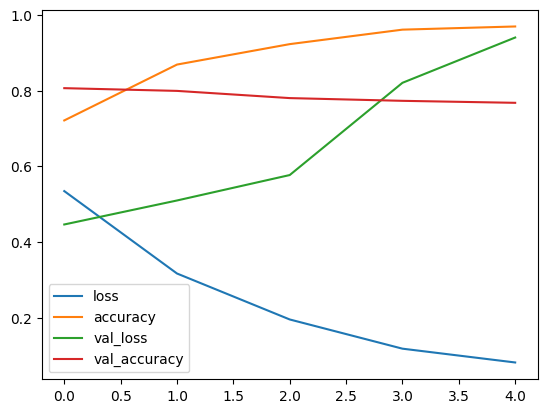

In [54]:
import pandas as pd
pd.DataFrame(history.history).plot()

## Creating Universal Sentence Unit Model using TensorFlow-Hub

In [55]:
## Using tensorflow-hub
import tensorflow_hub as hub
sentense_encode_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      input_shape=[],
                                      dtype='string',
                                      trainable=False,
                                      name="USE")

In [56]:
## Creating model with Sequential API
model_1 = tf.keras.models.Sequential([
        sentense_encode_layer,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid', name='output_layer')
])

model_1.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [57]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 256832769 (979.74 MB)
Trainable params: 34945 (136.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [58]:
## Fit the model
history_1 = model_1.fit(train_sentence,
                        train_label,
                        epochs=10,
                        validation_data=(val_sentence, val_label))

Epoch 1/10
191/191 [==============================] - 6s 16ms/step - loss: 0.5082 - accuracy: 0.7773 - val_loss: 0.4181 - val_accuracy: 0.8122
Epoch 2/10
191/191 [==============================] - 5s 24ms/step - loss: 0.4070 - accuracy: 0.8213 - val_loss: 0.4077 - val_accuracy: 0.8247
Epoch 3/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3841 - accuracy: 0.8322 - val_loss: 0.4048 - val_accuracy: 0.8260
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3632 - accuracy: 0.8442 - val_loss: 0.4043 - val_accuracy: 0.8299
Epoch 5/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3368 - accuracy: 0.8585 - val_loss: 0.4026 - val_accuracy: 0.8280
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3097 - accuracy: 0.8760 - val_loss: 0.4164 - val_accuracy: 0.8280
Epoch 7/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2781 - accuracy: 0.8898 - val_loss: 0.4170 - val_accuracy: 0.8313

<Axes: >

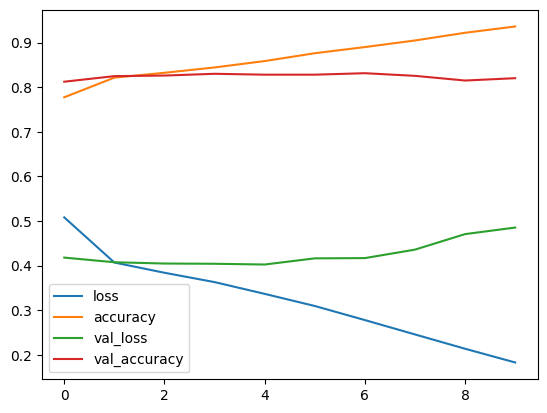

In [59]:
pd.DataFrame(history_1.history).plot()

## Predicting on train_data

In [60]:
## Predicting on train_data
y_preds = model_1.predict(train_data['text'])
y_preds = [0 if value < 0.5 else 1 for value in y_preds]
y_preds[:6]

238/238 [==============================] - 4s 15ms/step


[1, 1, 1, 1, 1, 1]

## Loading to dataframe

In [61]:
## Loading to a dataframe
predicted_dataframe = pd.DataFrame({'text': train_data['text'], 'preds': y_preds})
predicted_dataframe.head()

,text,preds
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [63]:
predicted_dataframe.tail()

,text,preds
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1
7612,The Latest: More Homes Razed by Northern Calif...,1


In [64]:
predicted_dataframe[predicted_dataframe['preds'] == 0]

,text,preds
15,What's up man?,0
16,I love fruits,0
17,Summer is lovely,0
18,My car is so fast,0
19,What a goooooooaaaaaal!!!!!!,0
...,...,...
7582,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,These boxes are ready to explode! Exploding Ki...,0
7587,Sirens everywhere!,0
7593,I just heard a really loud bang and everyone i...,0


In [65]:
len(predicted_dataframe[predicted_dataframe['preds'] == 0]) ## total 'not a disaster' tweets, predicted!

4604

In [66]:
len(predicted_dataframe[predicted_dataframe['preds'] == 1]) ## total 'disaster' tweets, predicted!

3009